# Trabajo Práctico 1
1. [Punto 1](#punto-1)
2. - [Punto 1.1](#punto-1-1) 
   - [Punto 1.2](#punto-1-2) 

## Punto 1.1 <a id="punto-1-1"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv(r"../data/raw/casas_dev.csv") 

df.sample(5, random_state=42)


,area,area_units,is_house,has_pool,age,price,lat,lon,rooms
70,872.0,sqft,0,0,11.0,630.0,40.718433,-74.008699,2.0
827,1076.0,sqft,0,0,7.0,772.0,40.707037,-73.998823,3.0
231,137.0,m2,0,0,10.0,214.0,-34.550223,-58.391268,4.0
588,775.0,sqft,1,1,10.0,751.0,40.726223,-74.043929,2.0
39,154.0,m2,1,0,16.0,273.0,-34.563525,-58.347365,4.0


In [3]:
# same 5 rows with at least 1 nan value (feature)
nan_rows = df[df.isna().any(axis=1)].sample(5, random_state=42)

nan_rows


,area,area_units,is_house,has_pool,age,price,lat,lon,rooms
874,98.0,m2,0,0,NaN,232.0,-34.591521,-58.389672,3.0
784,119.0,m2,1,1,NaN,226.0,-34.650660,-58.376238,4.0
122,102.0,m2,0,0,7.0,193.0,-34.615997,-58.372730,NaN
107,93.0,m2,1,0,7.0,184.0,-34.674335,-58.391795,NaN
343,431.0,sqft,0,0,2.0,324.0,40.703436,-74.002579,NaN


In [4]:
# convert sqft to m2
df.loc[df['area_units'] == 'sqft', 'area'] = df['area'] * 0.092903
df.loc[df['area_units'] == 'sqft', 'area_units'] = 'm2'

df.sample(5, random_state=42), df.shape

# delete area_units column
df = df.drop('area_units', axis=1)

In [5]:
from utils import get_nan_features


nan_features = get_nan_features(df)
nan_features



['age', 'rooms']

In [6]:
from utils import split_by_nan_features


has_nan_age, has_nan_rooms, has_nan_age_and_rooms, has_all_features = split_by_nan_features(df, nan_features)

has_nan_age.shape, has_nan_rooms.shape, has_nan_age_and_rooms.shape, has_all_features.shape


((117, 8), (59, 8), (13, 8), (711, 8))

In [7]:
from models.linear_regressor import LinearRegressor
from models.polinomial_regressor import PolinomialRegressor
from utils import train_model_for_feature

#TODO: Ver por que el modelo predice age solo de 10. 


# PolinomialRegressor.change_degree(1) = LinearRegressor

age_model, X_age_test, y_age_test = train_model_for_feature(PolinomialRegressor.change_degree(1),has_all_features[['rooms']], has_all_features['age'],seed=42)


rooms_model, X_rooms_test, y_rooms_test = train_model_for_feature(PolinomialRegressor.change_degree(1),has_all_features[['age']], has_all_features['rooms'])


age_and_room_model, X_multi_test, y_multi_test = train_model_for_feature(LinearRegressor,has_all_features[['area']], has_all_features[['age', 'rooms']])




In [8]:

age_mse = age_model.mse_score(X_age_test, y_age_test, round=True)
rooms_mse = rooms_model.mse_score(X_rooms_test, y_rooms_test)
multi_mse = age_and_room_model.mse_score(X_multi_test, y_multi_test)

print("Mean Squared Error for Age Model:", age_mse)
print("Mean Squared Error for Rooms Model:", rooms_mse)
print("Mean Squared Error for Multi Model:", multi_mse)

Mean Squared Error for Age Model: 17.718309859154928
Mean Squared Error for Rooms Model: 0.8827650263854404
Mean Squared Error for Multi Model: 8.99301318135667


In [9]:
#predict the missing values and rounding to the nearest integer

df.loc[df['age'].isnull(), 'age'] = np.round(age_model.predict(df[df['age'].isnull()][['rooms']]))
df.loc[df['rooms'].isnull(), 'rooms'] = np.round(rooms_model.predict(df[df['rooms'].isnull()][['age']]))
df.loc[df['age'].isnull() & df['rooms'].isnull(), ['age', 'rooms']] = np.round(age_and_room_model.predict(df[df['age'].isnull() & df['rooms'].isnull()][['area']]))
missing_values = df.isnull().sum()



if missing_values.sum() > 0:
    print("There are still missing values in the DataFrame:", missing_values)
else:
    print("All missing values have been successfully filled.")

# see df as a csv
df.to_csv(r"../data/processed/casas_dev.csv", index=False)

df.shape


All missing values have been successfully filled.


(900, 8)

## Punto 1.2 <a id="punto-1-2"></a>



<div style="padding: 10px; border-radius: 5px;">
    <p>
        Realice una serie de histogramas y diagramas de dispersión (scatterplots) para mostrar
        la relación entre las variables. Para esto, es útil el comando <code>pairplot</code>. 
        ¿Qué conclusiones puede extraer a simple vista acerca de las relaciones entre las variables? 
        Se permite la creación de gráficos adicionales que considere relevantes.
    </p>
</div>


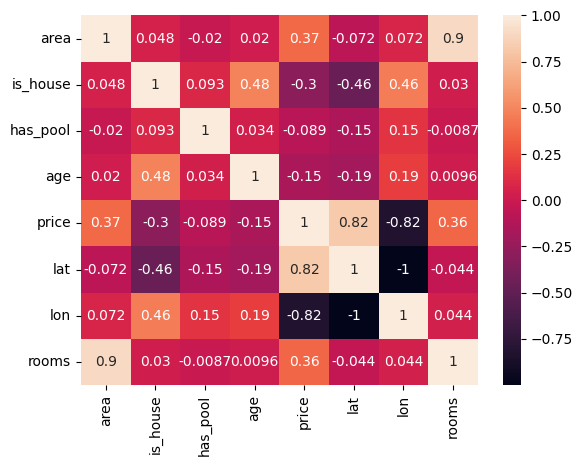

In [10]:
import seaborn as sns 


# show the correlation matrix
corr = df.corr()
sns.heatmap(corr, annot=True)
plt.show()

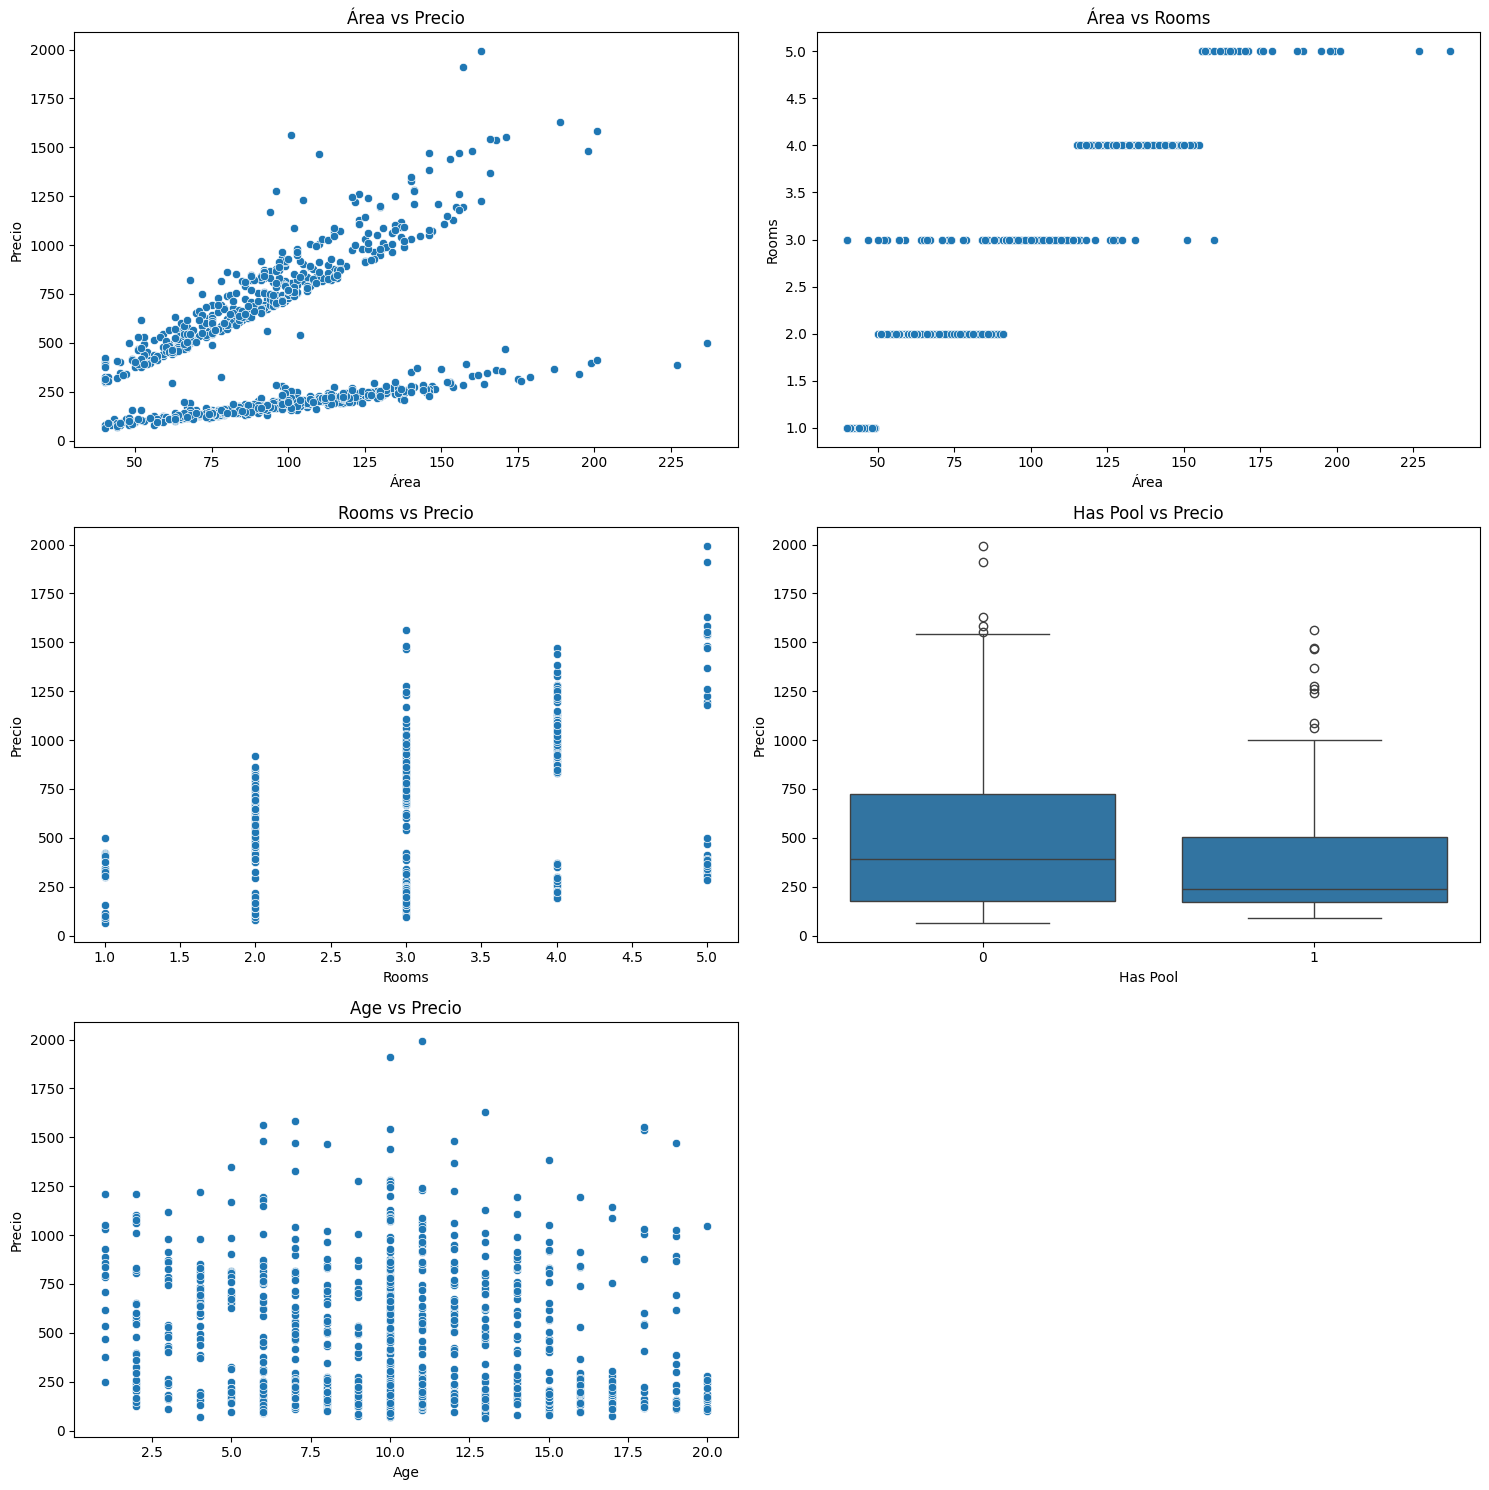

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv(r"../data/processed/casas_dev.csv")

# Crear una figura con subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# 1. Relación entre área y precio
sns.scatterplot(x='area', y='price', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Área vs Precio')
axes[0, 0].set_xlabel('Área')
axes[0, 0].set_ylabel('Precio')

# 2. Relación entre área y rooms
sns.scatterplot(x='area', y='rooms', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Área vs Rooms')
axes[0, 1].set_xlabel('Área')
axes[0, 1].set_ylabel('Rooms')

# 3. Relación entre rooms y precio
sns.scatterplot(x='rooms', y='price', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Rooms vs Precio')
axes[1, 0].set_xlabel('Rooms')
axes[1, 0].set_ylabel('Precio')

# 4. Relación entre has_pool y precio: Usamos boxplot porque has_pool es binaria
sns.boxplot(x='has_pool', y='price', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Has Pool vs Precio')
axes[1, 1].set_xlabel('Has Pool')
axes[1, 1].set_ylabel('Precio')

# 5. Relación entre age y precio
sns.scatterplot(x='age', y='price', data=df, ax=axes[2, 0])
axes[2, 0].set_title('Age vs Precio')
axes[2, 0].set_xlabel('Age')
axes[2, 0].set_ylabel('Precio')

fig.delaxes(axes[2, 1])

plt.tight_layout()
plt.show()

## Punto 1.3 <a id="punto-1-3"></a>


Divida el conjunto de desarrollo casas_dev.csv en un 80 % para entrenamiento (train)
y un 20 % para validación (validation). Estos conjuntos se utilizarán para entrenar y
validar los modelos que desarrollarán en las siguientes secciones. Se sugiere normalizar
los datos para lograr un mejora el condicionamiento numérico de los algortmos de
aprendizaje. Recuerde que si normaliza los datos, cuando haga una predicción deberá
invertir la normalización para volver a las escalas originales.

In [12]:
from models.data import split_test_train_without_label
import pandas as pd
df = pd.read_csv(r"../data/processed/casas_dev.csv")

df_train, df_test = split_test_train_without_label(df, test_size=0.2, random_state=42)


In [13]:

from models.linear_regressor import LinearRegressor
from models.polinomial_regressor import PolinomialRegressor
from models.data import split_test_train_with_label, split_test_train_without_label

df = pd.read_csv(r"../data/processed/casas_dev.csv")

X = df.drop('price', axis=1)
y = df['price']

#apply log to the price
y = np.log(y)

X_train, X_test, y_train, y_test = split_test_train_with_label(X, y, test_size=0.2, random_state=12)

model = LinearRegressor()
model.fit(X_train, y_train)
mse = model.mse_score(X_test, y_test)
print("Mean Squared Error:", mse)

r2_score = model.r2_score(X_test, y_test)

print("R2 Score:", r2_score)



Mean Squared Error: 0.012491962800103628
R2 Score: 0.9792688755026586


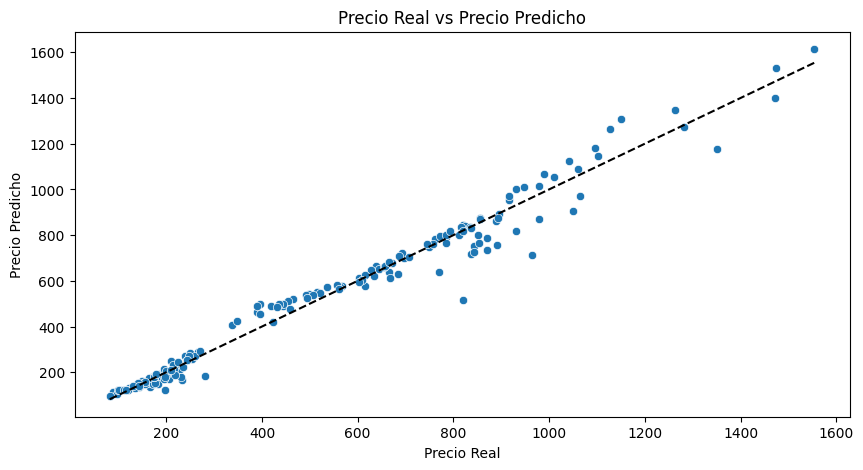

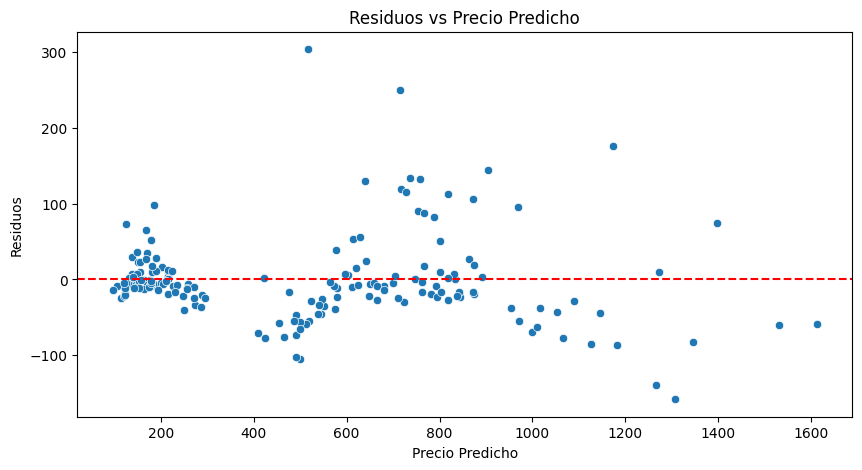

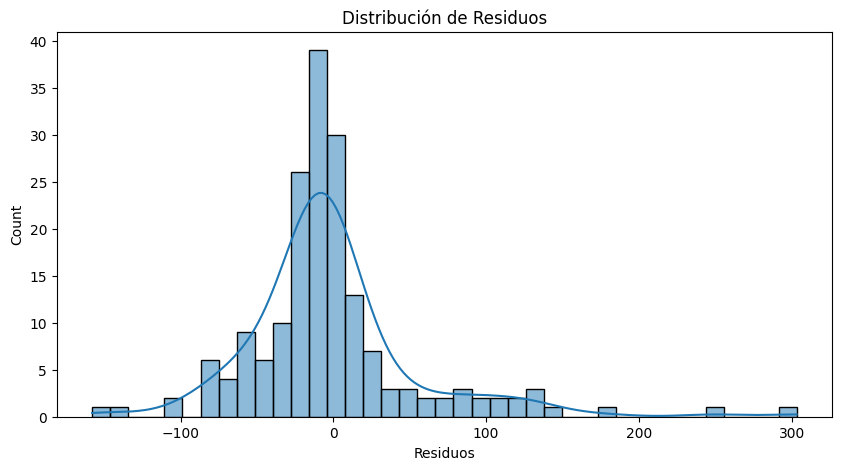

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict and transform back to original scale
y_pred = np.exp(model.predict(X_test))
y_true = np.exp(y_test)

# 1. Real vs Predicted scatter plot
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_true, y=y_pred)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--')  # add ideal line
plt.xlabel('Precio Real')
plt.ylabel('Precio Predicho')
plt.title('Precio Real vs Precio Predicho')
plt.show()

# 2. Residuals plot
plt.figure(figsize=(10, 5))
residuals = y_true - y_pred
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Precio Predicho')
plt.ylabel('Residuos')
plt.title('Residuos vs Precio Predicho')
plt.show()

# 3. Distribution of residuals
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuos')
plt.title('Distribución de Residuos')
plt.show()